In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
# install packages
import sys
!{sys.executable} -m pip install plotly  # you may want to restart your kernel if it can't find the plotly package
                                         # after installing it
!{sys.executable} -m pip install "notebook>=5.3"
!{sys.executable} -m pip install "ipywidgets>=7.5"

# load packages
from IPython.display import display, Markdown, clear_output

# set pandas
pd.set_option('display.max_columns', None)
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from collections import Counter
from scipy.stats import chi2
from scipy import stats
import pydicom

# clear stuff
clear_output()

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
display(all_xray_df.sample(3))

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index        Finding Labels  Follow-up #  Patient ID  \
9927   00002576_008.png            No Finding            8        2576   
15214  00003990_012.png  Atelectasis|Effusion           12        3990   
95942  00025252_003.png              Effusion            3       25252   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
9927            44              F            AP                 2500     2048   
15214           48              F            AP                 2500     2048   
95942           30              M            AP                 3056     2544   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
9927                         0.168  0.168          NaN  
15214                        0.171  0.171          NaN  
95942                        0.139  0.139          NaN

Image Index     Finding Labels  Follow-up #  Patient ID  \
4282  00021127_018.png          Pneumonia           18       21127   
4988  00026321_001.png  Atelectasis|Edema            1       26321   
4299  00021201_027.png       Infiltration           27       21201   

     Patient Age Patient Gender View Position  OriginalImageWidth  \
4282        065Y              M            PA                2992   
4988        041Y              F            AP                3056   
4299        065Y              M            AP                3056   

      OriginalImageHeight  OriginalImagePixelSpacing_x  \
4282                 2991                        0.143   
4988                 2544                        0.139   
4299                 2544                        0.139   

      OriginalImagePixelSpacing_y  
4282                        0.143  
4988                        0.139  
4299                        0.139

# preprocess

In [3]:
#
# delete column
#
if 'Unnamed: 11' in all_xray_df.columns:
    all_xray_df = all_xray_df.drop('Unnamed: 11', axis=1)

#
# categorise the labels into columns
#
if isinstance(all_xray_df['Finding Labels'].values[0], str):
    all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].str.split('|')
    
# grep all the labels
FINDING_LABELS = pd.Series(np.concatenate(all_xray_df['Finding Labels']).ravel())

for fn in FINDING_LABELS.value_counts().index:
    all_xray_df[fn] = [1 if fn in v else 0 for v in all_xray_df['Finding Labels']]
    
#
# Column which identicate if the findings contain Pneumonia  
#
all_xray_df['Pneumonia_Class'] = ['Has_Pneumonia' if v == 1 else 'Has_No_Pneumonia' for v in all_xray_df['Pneumonia']]

In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  No Finding                   112120 non-null  int64  
 12  Infiltration                 112120 non-null  int64  
 13 

## EDA

In [5]:
column = 'Patient Gender'

# general info
text  = f'## {column}  \n'
text += f'### General characteristics:  \n'
text += f'<b>Amount of unique values\'s</b>: {all_xray_df[column].nunique()}  \n'
text += f'<b>Amount of NaNs</b>: {all_xray_df[column].isnull().sum()}  \n'
display(Markdown(text))


# value counts if the items
text = '<b>Value Counts:</b>  \n'
v_sum = len(all_xray_df[column])
for k, v in all_xray_df[column].value_counts().items():
    text += f'<b>{k}</b>: {v} - ({np.around(v/v_sum*100,2)})%  \n'
display(Markdown(text))


# show the distribution
display(px.pie(all_xray_df[column].value_counts().reset_index(),  values=column, names='index', color='index'))



text = f'## {column} & Pneumonia \n'
display(Markdown(text))

#
# Show the distribution by pneumonia
#
pd_cross_tab = pd.crosstab(all_xray_df[column], all_xray_df['Pneumonia_Class'])
pd_cross_tab['Total'] = pd_cross_tab.sum(axis=1)
display(pd_cross_tab)

# show plot
pd_cross_tab = pd_cross_tab.sort_index(ascending=False)
display(px.bar( pd.melt(pd_cross_tab.reset_index(), id_vars=[column], value_vars=pd_cross_tab.reset_index().columns[1:-1]), 
        x= 'Pneumonia_Class', 
        y= 'value', 
        color='Patient Gender', 
        barmode='group'))

#
# chi² test
#
text = f'##  Chi²-Test \n'
display(Markdown(text))

# grep the data
cross_tab = pd.crosstab(all_xray_df[column], all_xray_df['Pneumonia_Class']).sort_index(ascending=False)

#cross_tab.loc[ 'F','Has_No_Pneumonia'] = 20000 # test to reject the 0 hypothesis
# Calculate the expected value
expected_values = cross_tab.sum(axis=1)[:,None] * np.ones((1,cross_tab.shape[1]))
expected_values *= (cross_tab.sum(axis=0).values * np.ones(cross_tab.shape))
expected_values /= cross_tab.sum().sum()

for e, col in enumerate(cross_tab.columns):
    cross_tab[f'Expected {col}'] = expected_values[:,e]

# calculate the chi square value
chi_square = (cross_tab.values[:,:expected_values.shape[1]] - expected_values)**2 / expected_values
chi_square= chi_square.sum().sum()

# calculate the degrees of freedom
degrees_of_freedom = (expected_values.shape[0] - 1) * (expected_values.shape[1] - 1)

# show result
display(np.around(cross_tab,2))
text = f'<b> Chi² value</b>: {np.around(chi_square,2)}  \n'
text += f'<b> P-value</b>: {0.05}  \n'
text += f'<b> Degrees of freedom</b>: {degrees_of_freedom}  \n'
display(Markdown(text))

if chi_square < chi2.isf(0.05, degrees_of_freedom):
    text = f'<span style="color:#009900; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is < the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we won\'t reject the nullhypothesis which means that there are no significan differences between both groups'
else:
    text = f'<span style="color:#990000; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is > the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we will reject the nullhypothesis which means that there is a significan differences between both groups'

display(Markdown(text))

## Patient Gender  
### General characteristics:  
<b>Amount of unique values's</b>: 2  
<b>Amount of NaNs</b>: 0  


<b>Value Counts:</b>  
<b>M</b>: 63340 - (56.49)%  
<b>F</b>: 48780 - (43.51)%  


## Patient Gender & Pneumonia 


Pneumonia_Class  Has_No_Pneumonia  Has_Pneumonia  Total
Patient Gender                                         
F                           48187            593  48780
M                           62502            838  63340

##  Chi²-Test 


Pneumonia_Class  Has_No_Pneumonia  Has_Pneumonia  Expected Has_No_Pneumonia  \
Patient Gender                                                                
M                           62502            838                   62531.58   
F                           48187            593                   48157.42   

Pneumonia_Class  Expected Has_Pneumonia  
Patient Gender                           
M                                808.42  
F                                622.58

<b> Chi² value</b>: 2.52  
<b> P-value</b>: 0.05  
<b> Degrees of freedom</b>: 1  


<span style="color:#009900; font-weight:900"> The chi² value of 2.52 is < the critical value of 3.84</span>:  
Therefore we won't reject the nullhypothesis which means that there are no significan differences between both groups

### Conclusion:
Based on the above information we notice that there are more males in our dataset then females,  
<b>but</b> based on the chi² test, gender does not have a significant influence on <i>Pneumonia</i>

In [6]:
column = 'Patient Age'

text = f'### {column}  \n'
text += f'#### General characteristics:  \n'
text += f'<b>Amount of unique values\'s</b>: {all_xray_df[column].nunique()}  \n'
text += f'<b>Amount of NaNs</b>: {all_xray_df[column].isnull().sum()}  \n'
text += f'<b>Amount of outliers</b>: {(all_xray_df[column] > 120).sum()}  \n'
display(Markdown(text))


text = '<span style="color:#ff0000; font-weight:900"> Note that I\'ve removed the outliers for the next stats!</span>  \n'
all_xray_df_without_outliers = all_xray_df[all_xray_df[column] < 120]
for k, v in all_xray_df_without_outliers.describe()[column].astype(np.int32).items():
    text += f'<b>{k}</b>: {v}  \n'
display(Markdown(text))
 
#
# student t-test
#    
text = f'## T-Test \n'
display(Markdown(text))

display(np.around(all_xray_df_without_outliers.groupby('Pneumonia_Class').agg({column: ['min', 
                                                                                        'mean',
                                                                                        'max', 
                                                                                        'std', 
                                                                                        "median", 
                                                                                        'size']}).T, 2)
       )

display(px.histogram(all_xray_df_without_outliers, 
             x=column, 
             color = 'Pneumonia_Class', 
             nbins=100, 
             log_y=True,
             barmode='overlay', 
             title='Log - Histogram',
             opacity=0.75))

display(Markdown('<b>Result t-test</b>'))
display(stats.ttest_ind(all_xray_df_without_outliers.loc[all_xray_df_without_outliers.Pneumonia_Class == 'Has_No_Pneumonia', column].values,
                all_xray_df_without_outliers.loc[all_xray_df_without_outliers.Pneumonia_Class == 'Has_Pneumonia', column].values,
                equal_var = False))




text = f'## Chi²-Test \n'
display(Markdown(text))

# grep the data
all_xray_df_without_outliers = all_xray_df_without_outliers.sort_values(column).copy()
bins = np.array(list(range(0,101,5)))
inds = np.digitize(all_xray_df_without_outliers[column], bins) 
all_xray_df_without_outliers[f'{column}_bins'] = [ f'[{bins[inds[n]-1]} - {bins[inds[n]]}[' for n in range(len(inds))]

cross_tab = pd.crosstab(all_xray_df_without_outliers[f'{column}_bins'], all_xray_df_without_outliers['Pneumonia_Class'])
#cross_tab = cross_tab.sort_index()

#cross_tab.loc[ 'F','Has_No_Pneumonia'] = 20000 # test to reject the 0 hypothesis
# Calculate the expected value
expected_values = cross_tab.sum(axis=1)[:,None] * np.ones((1,cross_tab.shape[1]))
expected_values *= (cross_tab.sum(axis=0).values * np.ones(cross_tab.shape))
expected_values /= cross_tab.sum().sum()

for e, col in enumerate(cross_tab.columns):
    cross_tab[f'Expected {col}'] = expected_values[:,e]

# calculate the chi square value
chi_square = (cross_tab.values[:,:expected_values.shape[1]] - expected_values)**2 / expected_values
chi_square= chi_square.sum().sum()

# calculate the degrees of freedom
degrees_of_freedom = (expected_values.shape[0] - 1) * (expected_values.shape[1] - 1)

# show result
display(np.around(cross_tab,2))

ct_i = cross_tab.reset_index()
ct_i['i'] = [ int(x.split(' ', 1)[0][1:]) for x in ct_i['Patient Age_bins']]
ct_i = ct_i.sort_values('i')
ct_i['Patient Age_bins'] = ct_i['Patient Age_bins'].astype(str)
display(px.bar(pd.melt(frame = ct_i, 
                       id_vars = ['Patient Age_bins'], 
                       value_vars = ['Has_Pneumonia','Expected Has_Pneumonia']), 
               x='Patient Age_bins', 
               y='value',
               color= 'Pneumonia_Class',
               barmode='group',
               title='Histogram',
               opacity=0.75))



text = f'<b> Chi² value</b>: {np.around(chi_square,2)}  \n'
text += f'<b> P-value</b>: {0.05}  \n'
text += f'<b> Degrees of freedom</b>: {degrees_of_freedom}  \n'
display(Markdown(text))

if chi_square < chi2.isf(0.05, degrees_of_freedom):
    text = f'<span style="color:#009900; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is < the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we won\'t reject the nullhypothesis which means that there are no significan differences between both groups'
else:
    text = f'<span style="color:#990000; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is > the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we will reject the nullhypothesis which means that there is a significan differences between both groups'

display(Markdown(text))

### Patient Age  
#### General characteristics:  
<b>Amount of unique values's</b>: 107  
<b>Amount of NaNs</b>: 0  
<b>Amount of outliers</b>: 16  


<span style="color:#ff0000; font-weight:900"> Note that I've removed the outliers for the next stats!</span>  
<b>count</b>: 112104  
<b>mean</b>: 46  
<b>std</b>: 16  
<b>min</b>: 1  
<b>25%</b>: 35  
<b>50%</b>: 49  
<b>75%</b>: 59  
<b>max</b>: 95  


## T-Test 


Pneumonia_Class     Has_No_Pneumonia  Has_Pneumonia
Patient Age min                 1.00           2.00
            mean               46.90          44.67
            max                95.00          90.00
            std                16.58          17.64
            median             49.00          46.00
            size           110674.00        1430.00

<b>Result t-test</b>

Ttest_indResult(statistic=4.754533327241383, pvalue=2.185202488608713e-06)

## Chi²-Test 


Pneumonia_Class   Has_No_Pneumonia  Has_Pneumonia  Expected Has_No_Pneumonia  \
Patient Age_bins                                                               
[0 - 5[                        281              7                     284.33   
[10 - 15[                     1975             34                    1983.37   
[15 - 20[                     3359             53                    3368.48   
[20 - 25[                     5972             96                    5990.60   
[25 - 30[                     6636             94                    6644.15   
[30 - 35[                     8256            134                    8282.98   
[35 - 40[                     7816            107                    7821.93   
[40 - 45[                     9670            111                    9656.23   
[45 - 50[                    11810            140                   11797.57   
[5 - 10[                      1083             32                    1100.78   
[50 - 55[                    13030            134                   12996.08   
[55 - 60[                    14086            156                   14060.33   
[60 - 65[                    10849            129                   10837.96   
[65 - 70[                     8171            123                    8188.20   
[70 - 75[                     4399             43                    4385.34   
[75 - 80[                     2175             24                    2170.95   
[80 - 85[                      784             10                     783.87   
[85 - 90[                      258              2                     256.68   
[90 - 95[                       63              1                      63.18   
[95 - 100[                       1              0                       0.99   

Pneumonia_Class   Expected Has_Pneumonia  
Patient Age_bins                          
[0 - 5[                             3.67  
[10 - 15[                          25.63  
[15 - 20[                          43.52  
[20 - 25[                          77.40  
[25 - 30[                          85.85  
[30 - 35[                         107.02  
[35 - 40[                         101.07  
[40 - 45[                         124.77  
[45 - 50[                         152.43  
[5 - 10[                           14.22  
[50 - 55[                         167.92  
[55 - 60[                         181.67  
[60 - 65[                         140.04  
[65 - 70[                         105.80  
[70 - 75[                          56.66  
[75 - 80[                          28.05  
[80 - 85[                          10.13  
[85 - 90[                           3.32  
[90 - 95[                           0.82  
[95 - 100[                          0.01

<b> Chi² value</b>: 64.38  
<b> P-value</b>: 0.05  
<b> Degrees of freedom</b>: 19  


<span style="color:#990000; font-weight:900"> The chi² value of 64.38 is > the critical value of 30.14</span>:  
Therefore we will reject the nullhypothesis which means that there is a significan differences between both groups

According to the above tests, we can conclude that the distributions of <i>Has Pneumonia</i> and <i>Has No Pneumonia</i> are different based by age.  
This means that <i>Age</i> might have an influence on <i>Pneumonia</i>
 - In the chi² test, we expected that there are slightly more older patients but this isn't the case.

In [7]:
column = 'View Position'

# general info
text  = f'## {column}  \n'
text += f'### General characteristics:  \n'
text += f'<b>Amount of unique values\'s</b>: {all_xray_df[column].nunique()}  \n'
text += f'<b>Amount of NaNs</b>: {all_xray_df[column].isnull().sum()}  \n'
display(Markdown(text))


# value counts if the items
text = '<b>Value Counts:</b>  \n'
v_sum = len(all_xray_df)
for k, v in all_xray_df[column].value_counts().items():
    text += f'<b>{k}</b>: {v} - {np.around(v/v_sum*100,2)}%  \n'
display(Markdown(text))


# show the distribution
display(px.pie(all_xray_df[column].value_counts().reset_index(),  values=column, names='index', color='index'))



text = f'## {column} & Pneumonia \n'
display(Markdown(text))

#
# Show the distribution by pneumonia
#
pd_cross_tab = pd.crosstab(all_xray_df[column], all_xray_df['Pneumonia_Class'])
pd_cross_tab['Total'] = pd_cross_tab.sum(axis=1)
display(pd_cross_tab)

# show plot
pd_cross_tab = pd_cross_tab.sort_index(ascending=False)
display(px.bar( pd.melt(pd_cross_tab.reset_index(), id_vars=[column], value_vars=pd_cross_tab.reset_index().columns[1:-1]), 
        x= 'Pneumonia_Class', 
        y= 'value', 
        color=column, 
        barmode='group'))

#
# chi² test
#
text = f'##  Chi²-Test \n'
display(Markdown(text))

# grep the data
cross_tab = pd.crosstab(all_xray_df[column], all_xray_df['Pneumonia_Class']).sort_index(ascending=False)

#cross_tab.loc[ 'F','Has_No_Pneumonia'] = 20000 # test to reject the 0 hypothesis
# Calculate the expected value
expected_values = cross_tab.sum(axis=1)[:,None] * np.ones((1,cross_tab.shape[1]))
expected_values *= (cross_tab.sum(axis=0).values * np.ones(cross_tab.shape))
expected_values /= cross_tab.sum().sum()

for e, col in enumerate(cross_tab.columns):
    cross_tab[f'Expected {col}'] = expected_values[:,e]

# calculate the chi square value
chi_square = (cross_tab.values[:,:expected_values.shape[1]] - expected_values)**2 / expected_values
chi_square= chi_square.sum().sum()

# calculate the degrees of freedom
degrees_of_freedom = (expected_values.shape[0] - 1) * (expected_values.shape[1] - 1)

# show result
display(np.around(cross_tab,2))
text = f'<b> Chi² value</b>: {np.around(chi_square,2)}  \n'
text += f'<b> P-value</b>: {0.05}  \n'
text += f'<b> Degrees of freedom</b>: {degrees_of_freedom}  \n'
display(Markdown(text))

if chi_square < chi2.isf(0.05, degrees_of_freedom):
    text = f'<span style="color:#009900; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is < the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we won\'t reject the nullhypothesis which means that there are no significan differences between both groups'
else:
    text = f'<span style="color:#990000; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is > the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we will reject the nullhypothesis which means that there is a significan differences between both groups'

display(Markdown(text))

## View Position  
### General characteristics:  
<b>Amount of unique values's</b>: 2  
<b>Amount of NaNs</b>: 0  


<b>Value Counts:</b>  
<b>PA</b>: 67310 - 60.03%  
<b>AP</b>: 44810 - 39.97%  


## View Position & Pneumonia 


Pneumonia_Class  Has_No_Pneumonia  Has_Pneumonia  Total
View Position                                          
AP                          44009            801  44810
PA                          66680            630  67310

##  Chi²-Test 


Pneumonia_Class  Has_No_Pneumonia  Has_Pneumonia  Expected Has_No_Pneumonia  \
View Position                                                                 
PA                          66680            630                   66450.92   
AP                          44009            801                   44238.08   

Pneumonia_Class  Expected Has_Pneumonia  
View Position                            
PA                               859.08  
AP                               571.92

<b> Chi² value</b>: 154.83  
<b> P-value</b>: 0.05  
<b> Degrees of freedom</b>: 1  


<span style="color:#990000; font-weight:900"> The chi² value of 154.83 is > the critical value of 3.84</span>:  
Therefore we will reject the nullhypothesis which means that there is a significan differences between both groups

Conclusion: In the above stats, we can see that the distributions of laying ont their right (PA) or left (AP) side are significantly different.
It seems to be that it might be easier to detect <i>Pneumonia</i> when the patient lays on his left.

In [8]:
column = 'Finding Labels'

# select the labels
df_labels = pd.melt(all_xray_df, id_vars=['Pneumonia_Class'], value_vars=list(FINDING_LABELS.value_counts().index))
df_labels = df_labels[df_labels.value > 0]

# general info
text  = f'## {column}  \n'
text += f'### General characteristics:  \n'
text += f'<b>Amount of unique values\'s</b>: {df_labels["variable"].nunique()}  \n'
text += f'<b>Amount of NaNs</b>: {df_labels["variable"].isnull().sum()}  \n'
display(Markdown(text))


# value counts if the items
text = '<b>Value Counts:</b>  \n'
v_sum = len(df_labels["variable"])
for k, v in df_labels["variable"].value_counts().items():
    text += f'<b>{k}</b>: {v} - {np.around((v/v_sum)*100,2)}%  \n'
display(Markdown(text))


# show the distribution
display(px.pie(df_labels["variable"].value_counts().reset_index(),  values='variable', names='index', color='index'))

#
# Labels en pneumonia
#
text = f'## Labels & Pneumonia \n'
display(Markdown(text))

#
# Show the distribution by pneumonia
#
pd_cross_tab = pd.crosstab(df_labels.Pneumonia_Class, df_labels.variable)[list(FINDING_LABELS.value_counts().index)].T
pd_cross_tab['Total'] = pd_cross_tab.sum(axis=1)
display(pd_cross_tab)


#
# chi² test
#
text = f'## Chi²-Test \n<b>Note</b>, we\'ve remove the <i>Pneumonia</i> and <i>No Finding</i> label'

display(Markdown(text))

# grep the data
cross_tab = pd.crosstab(df_labels.Pneumonia_Class, df_labels.variable)[list(FINDING_LABELS.value_counts().index)].T
cross_tab = cross_tab[~cross_tab.index.isin(['No Finding','Pneumonia'])]

#cross_tab.loc[ 'F','Has_No_Pneumonia'] = 20000 # test to reject the 0 hypothesis
# Calculate the expected value
expected_values = cross_tab.sum(axis=1)[:,None] * np.ones((1,cross_tab.shape[1]))
expected_values *= (cross_tab.sum(axis=0).values * np.ones(cross_tab.shape))
expected_values /= cross_tab.sum().sum()

for e, col in enumerate(cross_tab.columns):
    cross_tab[f'Expected {col}'] = expected_values[:,e]

# calculate the chi square value
chi_square = (cross_tab.values[:,:expected_values.shape[1]] - expected_values)**2 / expected_values
chi_square= chi_square.sum().sum()

# calculate the degrees of freedom
degrees_of_freedom = (expected_values.shape[0] - 1) * (expected_values.shape[1] - 1)

# show result
display(np.around(cross_tab,2))
text = f'<b> Chi² value</b>: {np.around(chi_square,2)}  \n'
text += f'<b> P-value</b>: {0.05}  \n'
text += f'<b> Degrees of freedom</b>: {degrees_of_freedom}  \n'
display(Markdown(text))

if chi_square < chi2.isf(0.05, degrees_of_freedom):
    text = f'<span style="color:#009900; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is < the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we won\'t reject the nullhypothesis which means that there are no significan differences between both groups'
else:
    text = f'<span style="color:#990000; font-weight:900"> The chi² value of {np.around(chi_square, 2)} is > the critical value of {np.around(chi2.isf(0.05, degrees_of_freedom),2)}</span>:  \n'
    text += f'Therefore we will reject the nullhypothesis which means that there is a significan differences between both groups'

display(Markdown(text))


## Finding Labels  
### General characteristics:  
<b>Amount of unique values's</b>: 15  
<b>Amount of NaNs</b>: 0  


<b>Value Counts:</b>  
<b>No Finding</b>: 60361 - 42.65%  
<b>Infiltration</b>: 19894 - 14.06%  
<b>Effusion</b>: 13317 - 9.41%  
<b>Atelectasis</b>: 11559 - 8.17%  
<b>Nodule</b>: 6331 - 4.47%  
<b>Mass</b>: 5782 - 4.09%  
<b>Pneumothorax</b>: 5302 - 3.75%  
<b>Consolidation</b>: 4667 - 3.3%  
<b>Pleural_Thickening</b>: 3385 - 2.39%  
<b>Cardiomegaly</b>: 2776 - 1.96%  
<b>Emphysema</b>: 2516 - 1.78%  
<b>Edema</b>: 2303 - 1.63%  
<b>Fibrosis</b>: 1686 - 1.19%  
<b>Pneumonia</b>: 1431 - 1.01%  
<b>Hernia</b>: 227 - 0.16%  


## Labels & Pneumonia 


Pneumonia_Class     Has_No_Pneumonia  Has_Pneumonia  Total
variable                                                  
No Finding                     60361              0  60361
Infiltration                   19289            605  19894
Effusion                       13048            269  13317
Atelectasis                    11297            262  11559
Nodule                          6261             70   6331
Mass                            5711             71   5782
Pneumothorax                    5261             41   5302
Consolidation                   4544            123   4667
Pleural_Thickening              3337             48   3385
Cardiomegaly                    2735             41   2776
Emphysema                       2493             23   2516
Edema                           1963            340   2303
Fibrosis                        1675             11   1686
Pneumonia                          0           1431   1431
Hernia                           224              3    227

## Chi²-Test 
<b>Note</b>, we've remove the <i>Pneumonia</i> and <i>No Finding</i> label

Pneumonia_Class     Has_No_Pneumonia  Has_Pneumonia  \
variable                                              
Infiltration                   19289            605   
Effusion                       13048            269   
Atelectasis                    11297            262   
Nodule                          6261             70   
Mass                            5711             71   
Pneumothorax                    5261             41   
Consolidation                   4544            123   
Pleural_Thickening              3337             48   
Cardiomegaly                    2735             41   
Emphysema                       2493             23   
Edema                           1963            340   
Fibrosis                        1675             11   
Hernia                           224              3   

Pneumonia_Class     Expected Has_No_Pneumonia  Expected Has_Pneumonia  
variable                                                               
Infiltration                         19418.26                  475.74  
Effusion                             12998.54                  318.46  
Atelectasis                          11282.58                  276.42  
Nodule                                6179.60                  151.40  
Mass                                  5643.73                  138.27  
Pneumothorax                          5175.21                  126.79  
Consolidation                         4555.39                  111.61  
Pleural_Thickening                    3304.05                   80.95  
Cardiomegaly                          2709.62                   66.38  
Emphysema                             2455.83                   60.17  
Edema                                 2247.93                   55.07  
Fibrosis                              1645.68                   40.32  
Hernia                                 221.57                    5.43

<b> Chi² value</b>: 1764.02  
<b> P-value</b>: 0.05  
<b> Degrees of freedom</b>: 12  


<span style="color:#990000; font-weight:900"> The chi² value of 1764.02 is > the critical value of 21.03</span>:  
Therefore we will reject the nullhypothesis which means that there is a significan differences between both groups

Conclusion: There are some labels which are highly corrolated with Pneumonia:
 - Edema
 - Infiltration  
   
\+ Both distributions are different

# Records with Pneumonia

In [9]:
display(all_xray_df.Pneumonia_Class.value_counts().reset_index())
display(px.pie(all_xray_df.Pneumonia_Class.value_counts().reset_index(),  
               values='Pneumonia_Class', 
               names='index',
               color='index'))


index  Pneumonia_Class
0  Has_No_Pneumonia           110689
1     Has_Pneumonia             1431

# Number of disease per patient 

In [10]:
labels = FINDING_LABELS.value_counts().index

# count the disease per patient
text  = f"Amount of patients: {all_xray_df['Patient ID'].nunique()}  \n"
amount_of_no_diseases = all_xray_df.groupby('Patient ID').agg({c : 'max' for c in labels if c not in ['No Finding']}).sum(axis=1).value_counts()[0]
text += f"Amount of patients without a disease: {amount_of_no_diseases} - {np.around(amount_of_no_diseases / all_xray_df['Patient ID'].nunique() * 100,2)}%  \n"
text += f"Amount of patients with a deasease: {all_xray_df['Patient ID'].nunique() - amount_of_no_diseases} - {np.around((all_xray_df['Patient ID'].nunique() - amount_of_no_diseases) / all_xray_df['Patient ID'].nunique() * 100,2)}%  \n"
display(Markdown(text))

df_disease_per_patient = all_xray_df.groupby('Patient ID').agg({c : 'max' for c in labels if c not in ['No Finding']}).sum(axis=1).value_counts().reset_index()
df_disease_per_patient.columns = ['Amount of Diseases', 'Amount of Patients']
df_disease_per_patient['%Patients'] = np.around(df_disease_per_patient['Amount of Patients'] / df_disease_per_patient['Amount of Patients'].sum(axis=0)*100, 2)
display(df_disease_per_patient)

display(px.pie(df_labels["variable"].value_counts().reset_index(),  values='variable', names='index', color='index'))

Amount of patients: 30805  
Amount of patients without a disease: 16403 - 53.25%  
Amount of patients with a deasease: 14402 - 46.75%  


Amount of Diseases  Amount of Patients  %Patients
0                    0               16403      53.25
1                    1                6742      21.89
2                    2                2908       9.44
3                    3                1638       5.32
4                    4                1087       3.53
5                    5                 707       2.30
6                    6                 518       1.68
7                    7                 335       1.09
8                    8                 205       0.67
9                    9                 139       0.45
10                  10                  84       0.27
11                  11                  28       0.09
12                  12                   7       0.02
13                  13                   4       0.01

Note, if a patient has a disease, it is most likely that it is only 1 disease.

# The distribution of other diseases that are comorbid with pneumonia

In [11]:
labels = [x for x in FINDING_LABELS.value_counts().index]


co_occurence_matrix = all_xray_df[all_xray_df['Pneumonia_Class'] == 'Has_Pneumonia'][labels].T.dot(all_xray_df[all_xray_df['Pneumonia_Class'] == 'Has_Pneumonia'][labels])
# normalize the data
co_occurence_matrix = np.around(co_occurence_matrix / all_xray_df[all_xray_df['Pneumonia_Class'] == 'Has_Pneumonia'].shape[0], 2)

# show to co-occurence matrix
cm = sns.light_palette("green", as_cmap=True)
s = co_occurence_matrix.style.background_gradient(cmap=cm)
s

Note, from the above stats, we see that Pneumonia is co-occur frequently with:
- Infiltration
- Edema
- Effusion	
- Atelectasis

# Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [12]:

def plot_image_info(data, info, img=None, norm_modus = 0):
    
    if img is None:
        img = img = plt.imread(data['IMAGE_PATH'])
    
    ## normalize image
    img = (img - img.mean())/img.std() if norm_modus == 0 else img/255

    
    ## plot the image and its pixel intensity distribution    
    fig = plt.figure()
    fig.set_figwidth(20)
    
    ## Plotting Image    
    sub1 = fig.add_subplot(1,2,1)
    sub1.set_title(f'X-Ray - Patient-ID: ' + ' - '.join([str(data[x]) for x in info]))
    sub1.imshow(img, cmap='gray')
    
    ## Plotting Pixel Intensity    
    sub2 = fig.add_subplot(1,2,2)
    sub2.set_title(f'Pixel Intensity')
    plt.hist(img.ravel(), bins=256)

## Dicom Data

Modality Study Description Patient ID Patient's Sex Patient's Age  \
3       DX      Cardiomegaly          1             M            58   
0       CT        No Finding          2             M            81   
1       DX        No Finding          2             M            81   
2       DX        No Finding          2             M            81   
5       DX        No Finding          2             M            81   
4       DX          Effusion         61             M            77   

  Body Part Examined Patient Position  Samples per Pixel  \
3              CHEST               AP                  1   
0              CHEST               PA                  1   
1            RIBCAGE               PA                  1   
2              CHEST               XX                  1   
5              CHEST               PA                  1   
4              CHEST               AP                  1   

  Photometric Interpretation  Rows  Columns  Bits Allocated  Bits Stored  \
3                MONOCHROME2  1024     1024               8            8   
0                MONOCHROME2  1024     1024               8            8   
1                MONOCHROME2  1024     1024               8            8   
2                MONOCHROME2  1024     1024               8            8   
5                MONOCHROME2  1024     1024               8            8   
4                MONOCHROME2  1024     1024               8            8   

   High Bit  Pixel Representation  
3         7                     0  
0         7                     0  
1         7                     0  
2         7                     0  
5         7                     0  
4         7                     0

## Dicom Images

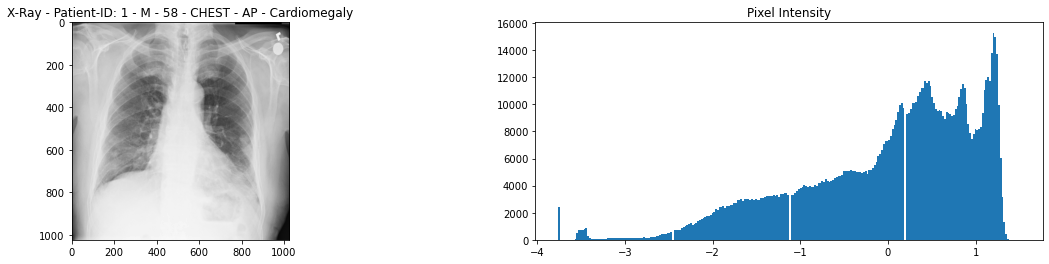

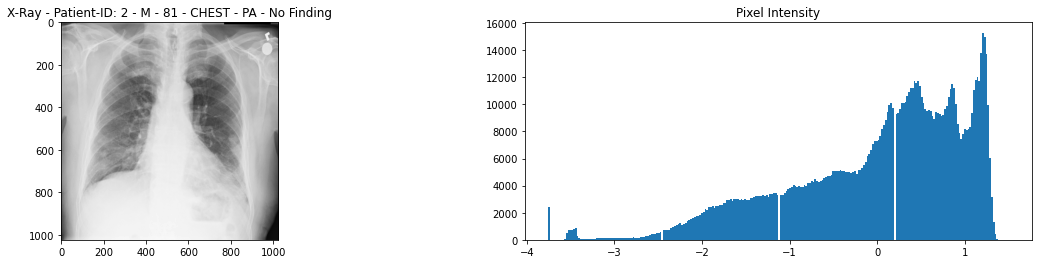

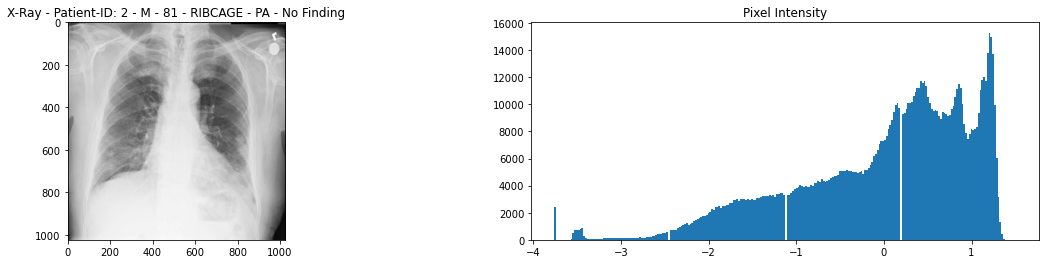

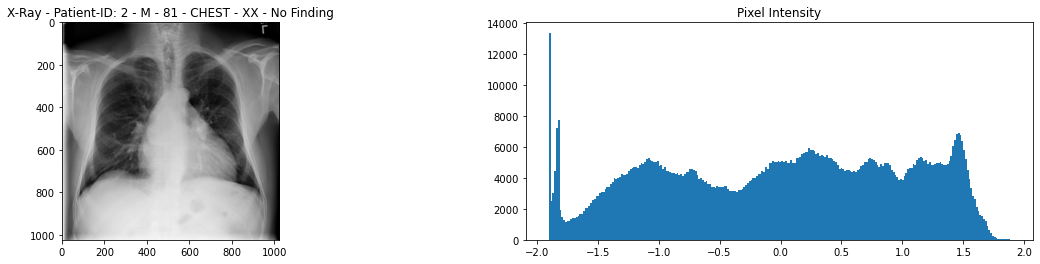

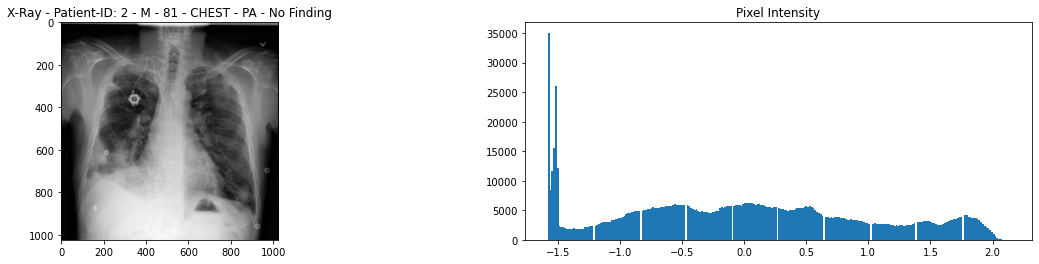

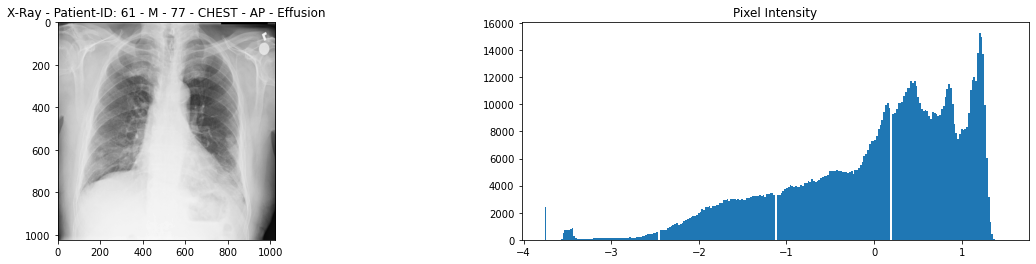

In [13]:
df_dcm = []
scans = []

#loop over the dicom data
for dcm_file in glob('*dcm'):
    
    # get the info
    dcm = pydicom.dcmread(dcm_file)
    
    # get the info
    info = {}
    for key in dcm.keys():
        
        if ' UID' in dcm[key].name:
            continue
            
        if 'Pixel Data' == dcm[key].name:
            scans.append(dcm.pixel_array)
            continue

        info[dcm[key].name] = dcm[key].value
    
    # add to list
    df_dcm.append(info)  
    
df_dcm = pd.DataFrame(df_dcm).sort_values('Patient ID')

text= f'## Dicom Data'
display(Markdown(text))
display(df_dcm)

text= f'## Dicom Images'
display(Markdown(text))
for img, (_, row) in zip(scans, df_dcm.iterrows()):
    plot_image_info(row, 
                    info = ['Patient ID',"Patient's Sex", "Patient's Age", "Body Part Examined", 'Patient Position', 'Study Description'],
                    img = img, 
                    norm_modus=0)

# Sample Data

In [14]:
#
# categorise the labels into columns
#
if isinstance(sample_df['Finding Labels'].values[0], str):
    sample_df['Finding Labels'] = sample_df['Finding Labels'].str.split('|')
    
# grep all the labels
FINDING_LABELS = pd.Series(np.concatenate(sample_df['Finding Labels']).ravel())
FINDING_LABELS_U = np.unique(FINDING_LABELS)

for fn in FINDING_LABELS.value_counts().index:
    sample_df[fn] = [1 if fn in v else 0 for v in sample_df['Finding Labels']]
    
#
# Column which identicate if the findings contain Pneumonia  
#
sample_df['Pneumonia_Class'] = ['Has_Pneumonia' if v == 1 else 'Has_No_Pneumonia' for v in sample_df['Pneumonia']]

#
# images path
#
images_2_path = {x.rsplit('/', 1)[1] :x for x in glob('/data/images_*/images/*')}
sample_df['IMAGE_PATH'] = [images_2_path.get(x) for x in sample_df['Image Index']]

#
# sort_values 
#
sample_df = sample_df.sort_values(['Patient ID', 'Follow-up #'])
sample_df.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  [Emphysema, Infiltration, Pleural_Thickening, ...   
1  00000013_026.png                          [Cardiomegaly, Emphysema]   
2  00000017_001.png                                       [No Finding]   
3  00000030_001.png                                      [Atelectasis]   
4  00000032_001.png                    [Cardiomegaly, Edema, Effusion]   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  No Finding  Infiltration  Effusion  \
0                        0.139           0             1         0   
1                        0.168           0             0         0   
2                        0.168           1             0         0   
3                        0.143           0             0         0   
4                        0.168           0             0         1   

   Atelectasis  Nodule  Mass  Pneumothorax  Consolidation  Pleural_Thickening  \
0            0       0     0             1              0                   1   
1            0       0     0             0              0                   0   
2            0       0     0             0              0                   0   
3            1       0     0             0              0                   0   
4            0       0     0             0              0                   0   

   Cardiomegaly  Emphysema  Edema  Fibrosis  Pneumonia  Hernia  \
0             0          1      0         0          0       0   
1             1          1      0         0          0       0   
2             0          0      0         0          0       0   
3             0          0      0         0          0       0   
4             1          0      1         0          0       0   

    Pneumonia_Class                                IMAGE_PATH  
0  Has_No_Pneumonia  /data/images_001/images/00000013_005.png  
1  Has_No_Pneumonia  /data/images_001/images/00000013_026.png  
2  Has_No_Pneumonia  /data/images_001/images/00000017_001.png  
3  Has_No_Pneumonia  /data/images_001/images/00000030_001.png  
4  Has_No_Pneumonia  /data/images_001/images/00000032_001.png

## Healthy x-rayes

### Age - Gender

Images of patients with no disease

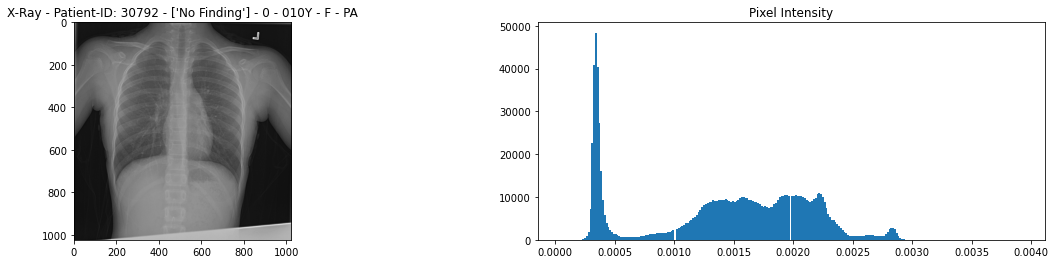

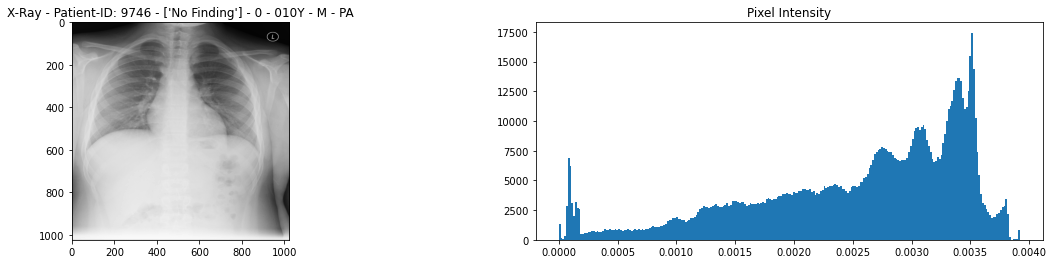

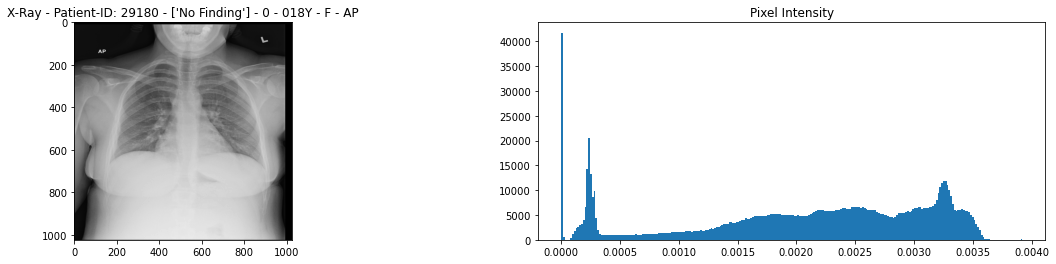

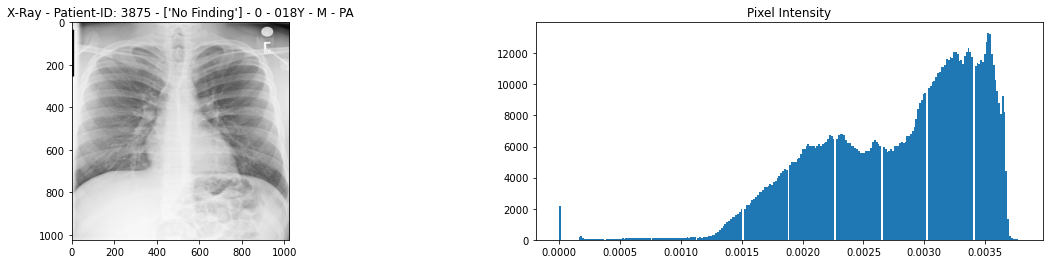

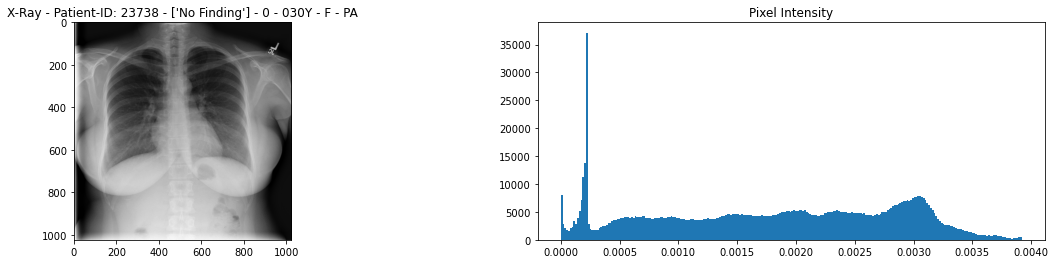

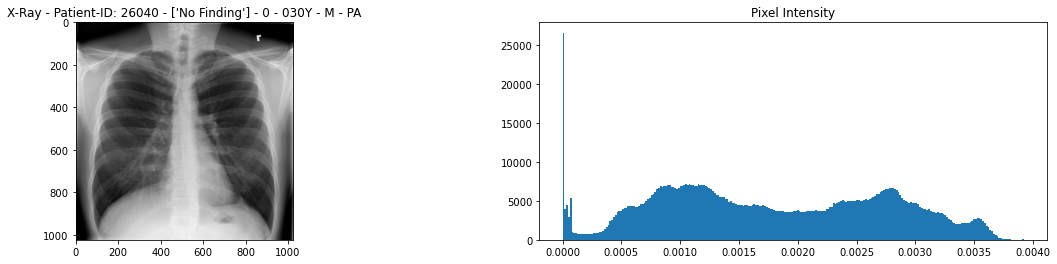

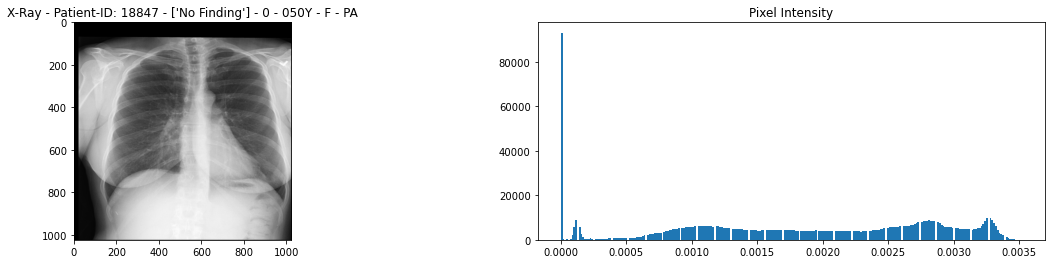

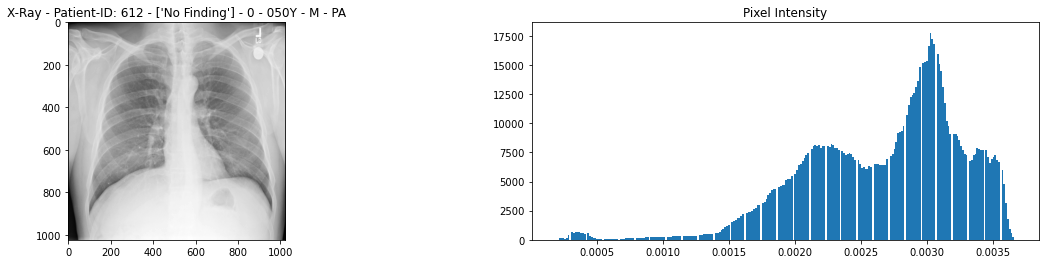

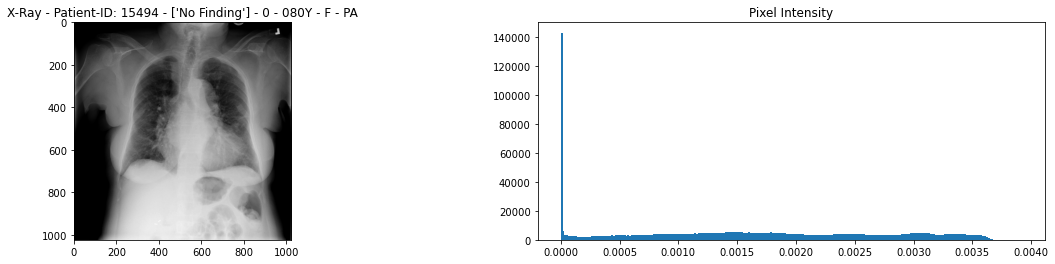

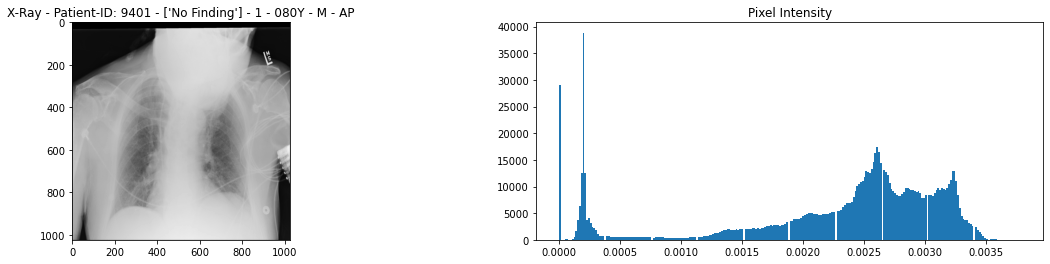

In [15]:
text= f'### Age - Gender'
display(Markdown(text))

text= f'Images of patients with no disease'
display(Markdown(text))

sample_df_tmp = sample_df[sample_df[FINDING_LABELS_U].sum(axis=1) == sample_df['No Finding']]
sample_df_tmp = sample_df_tmp.sample(sample_df_tmp.shape[0])
sample_df_tmp = sample_df_tmp[sample_df_tmp['Patient Age'].isin(['010Y', '018Y', '030Y', '050Y', '080Y'])]
sample_df_tmp = sample_df_tmp.sort_values(['Follow-up #','View Position'], ascending=[True, False])
sample_df_tmp = sample_df_tmp.drop_duplicates(subset= ['Patient Gender', 'Patient Age'])
sample_df_tmp = sample_df_tmp.sort_values(['Patient Age', 'Patient Gender'])

for _, row in sample_df_tmp.iterrows():
    plot_image_info(row, 
                    info = ['Patient ID', 'Finding Labels','Follow-up #','Patient Age','Patient Gender','View Position'],
                    img = None, 
                    norm_modus = 1)

### View Position

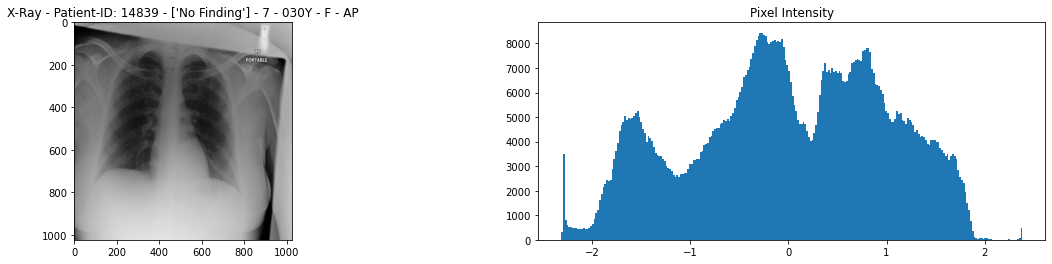

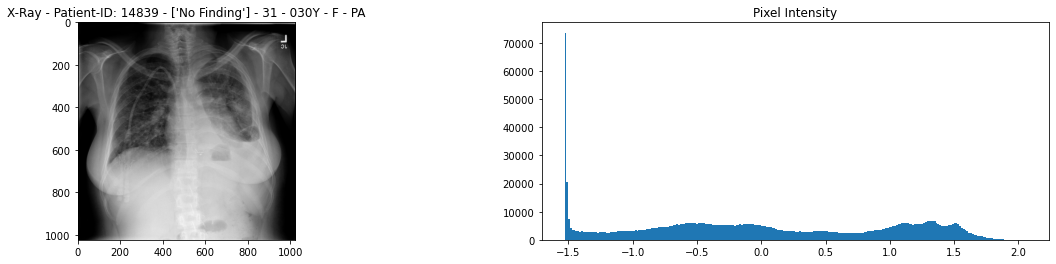

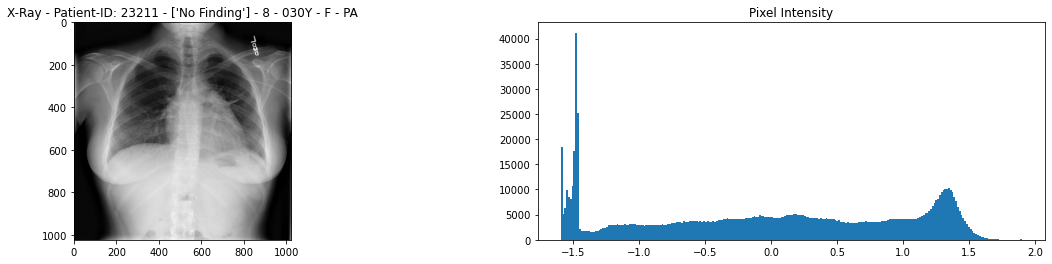

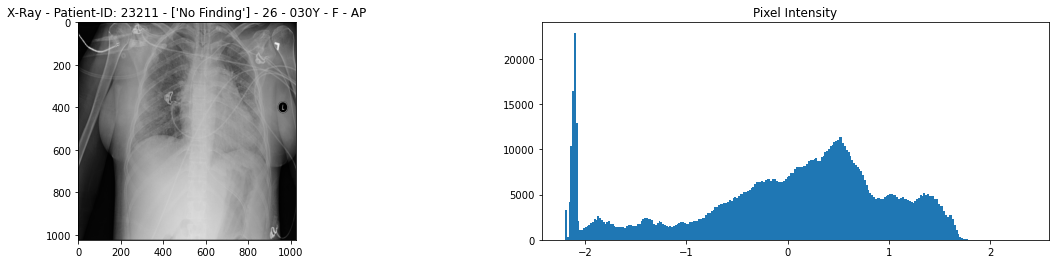

In [16]:
text= f'### View Position'
display(Markdown(text))

sample_df_tmp = sample_df[sample_df[FINDING_LABELS_U].sum(axis=1) == sample_df['No Finding']]
sample_df_tmp = sample_df_tmp[(sample_df_tmp['Patient Age'] == '030Y') ]
sample_df_tmp = sample_df_tmp.drop_duplicates(subset = ['Patient ID', 'View Position'])
sample_df_tmp['View Position Amount'] = sample_df_tmp.groupby(['Patient ID'])['View Position'].transform('count')
sample_df_tmp = sample_df_tmp[sample_df_tmp['View Position Amount'] > 1]



for _, row in sample_df_tmp.iterrows():
    plot_image_info(row, 
                    info = ['Patient ID', 'Finding Labels','Follow-up #','Patient Age','Patient Gender','View Position'],
                    img = None, 
                    norm_modus = 0)

### Different Diseases 

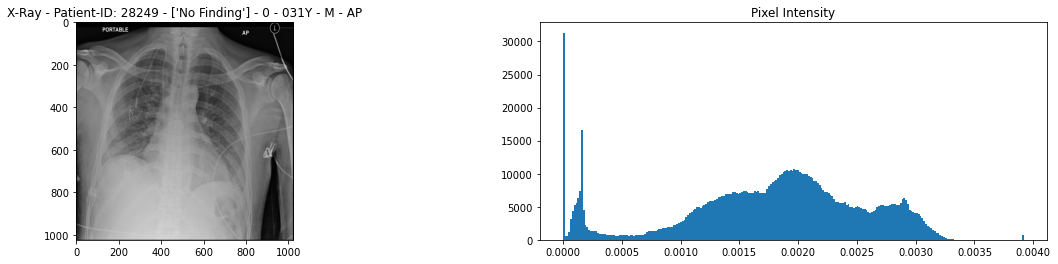

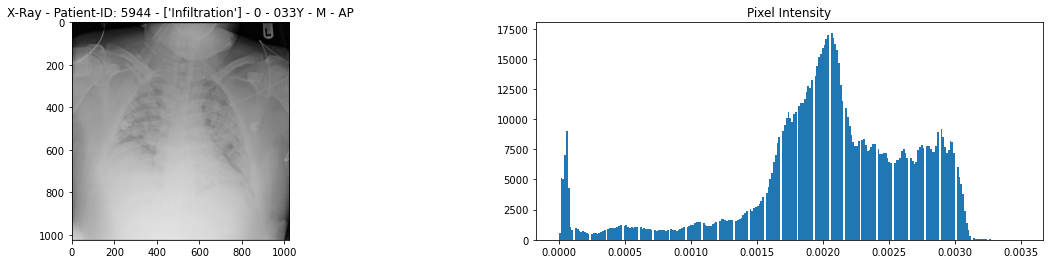

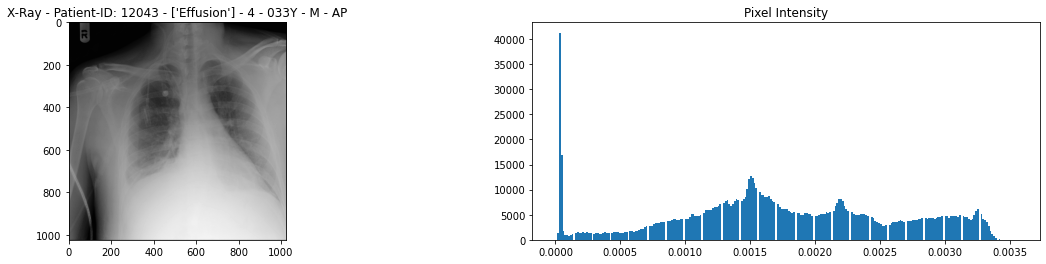

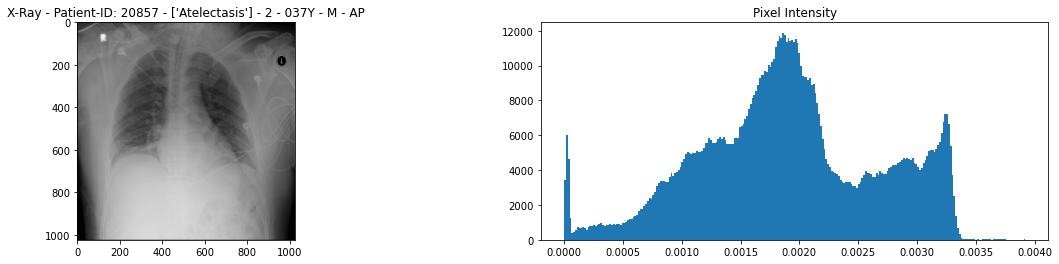

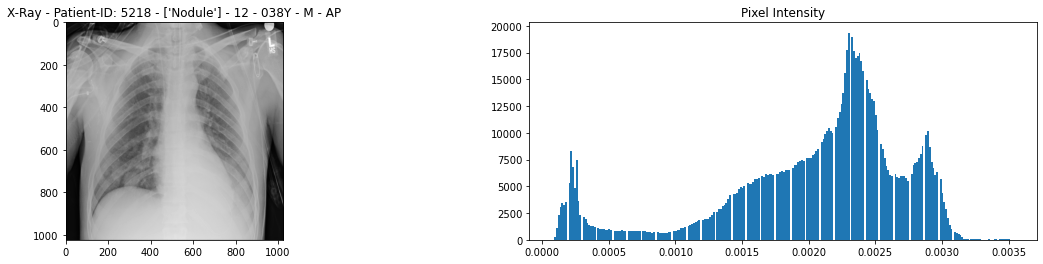

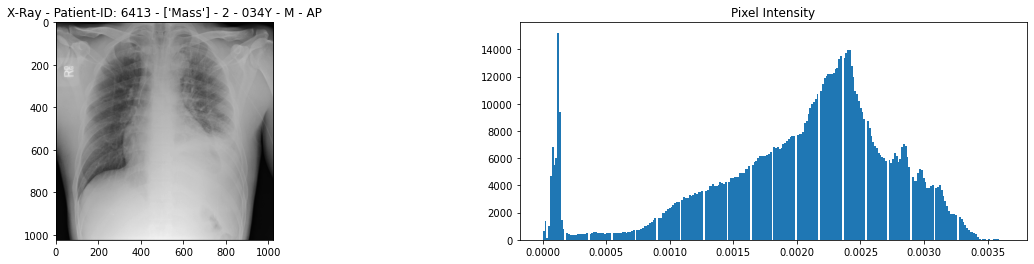

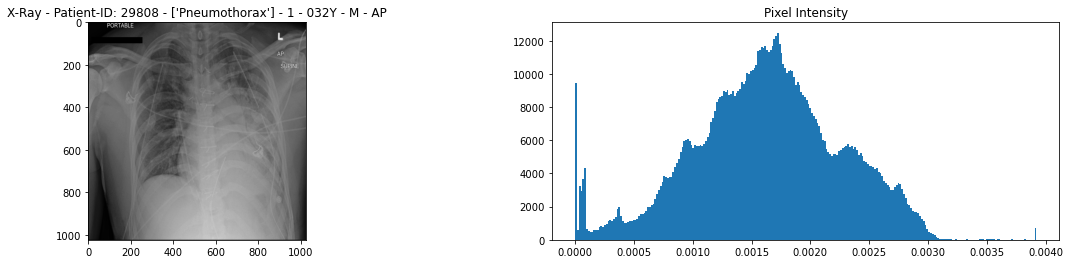

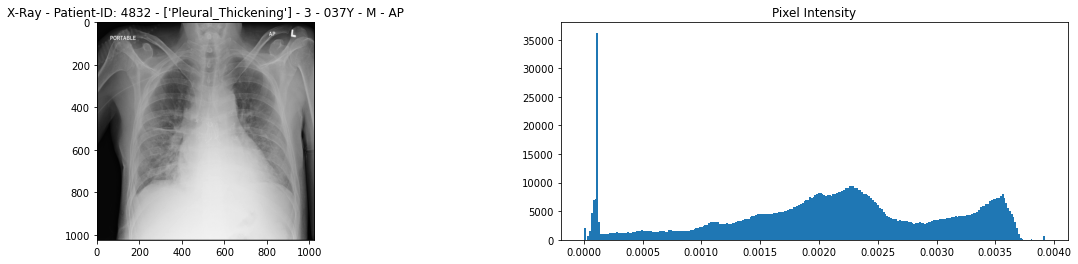

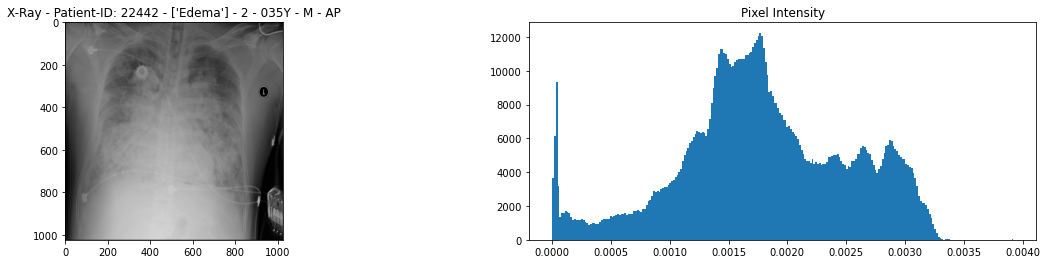

In [17]:
text= f'### Different Diseases '
display(Markdown(text))

for finding in FINDING_LABELS.value_counts().index:
    sample_df_tmp = sample_df[sample_df[FINDING_LABELS_U].sum(axis=1) == sample_df[finding]]
    sample_df_tmp = sample_df_tmp[(sample_df_tmp['Patient Age'].isin([f'0{i}Y' for i in range(30,40)])) & \
                                  (sample_df_tmp['Patient Gender'] == 'M') & \
                                  (sample_df_tmp['View Position'] == 'AP') ]
    sample_df_tmp = sample_df_tmp.sort_values(['Follow-up #'])

    for _, row in sample_df_tmp[:1].iterrows():
        plot_image_info(row, 
                        info = ['Patient ID', 'Finding Labels','Follow-up #','Patient Age','Patient Gender','View Position'],
                        img = None, 
                        norm_modus = 1)

### Pneumonia vs No Pneumonia

Images & distributions of patients with different ages and gender

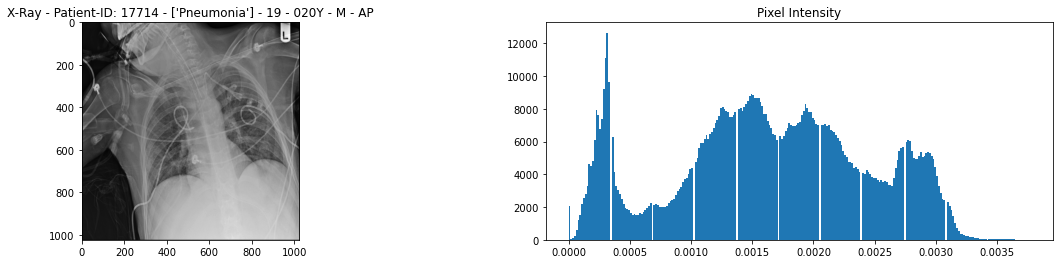

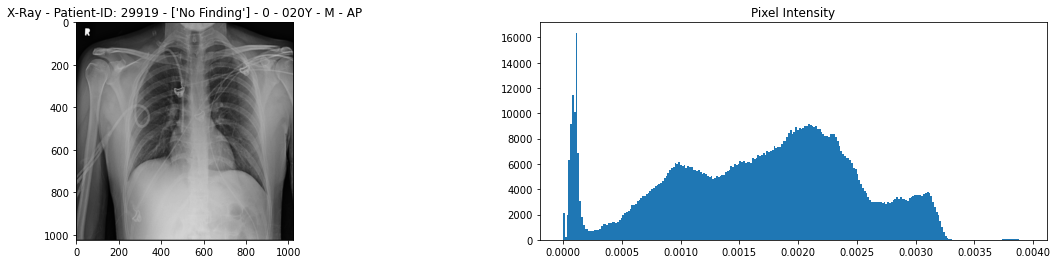

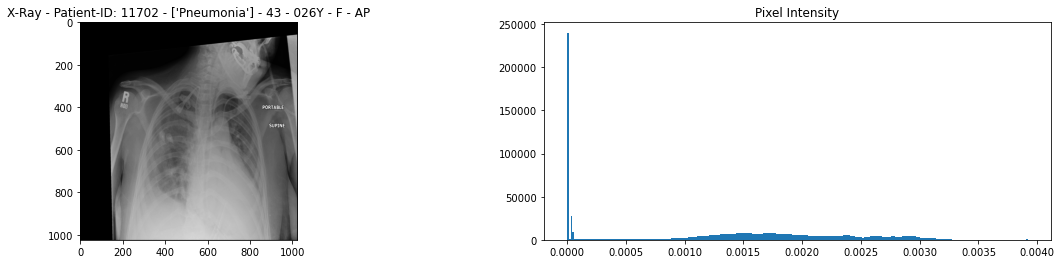

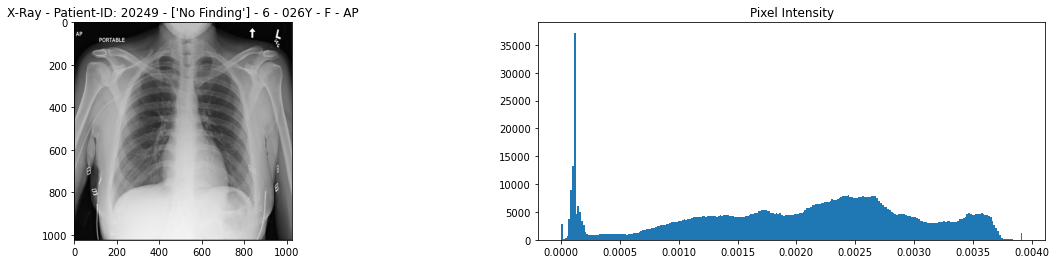

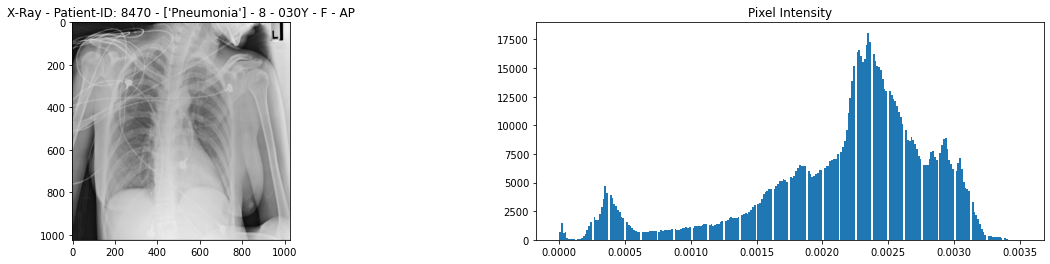

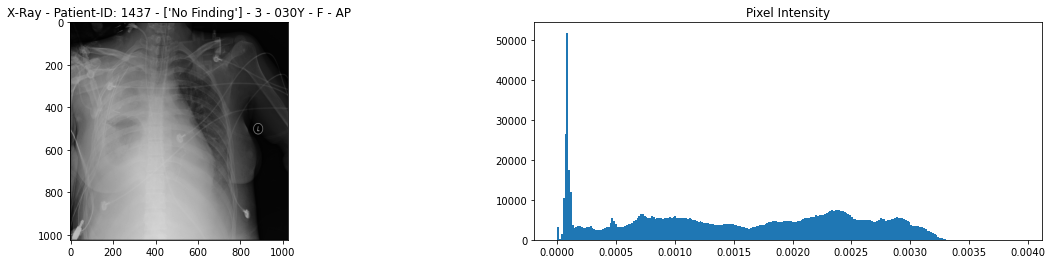

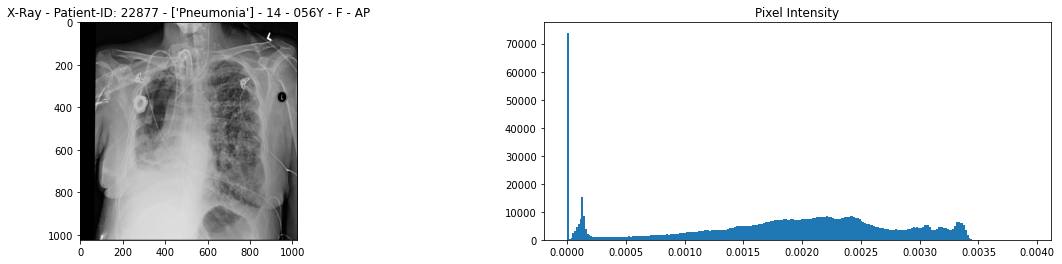

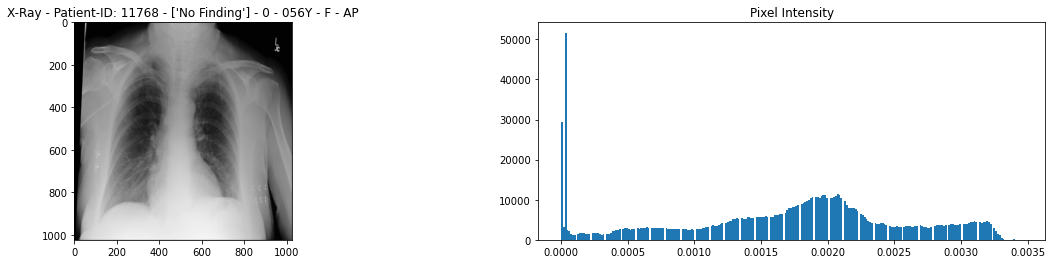

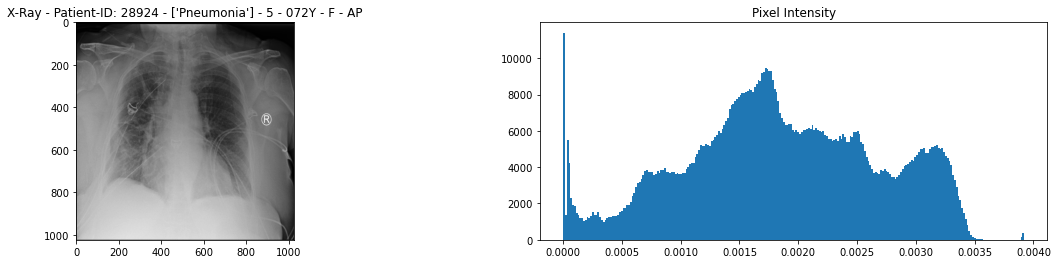

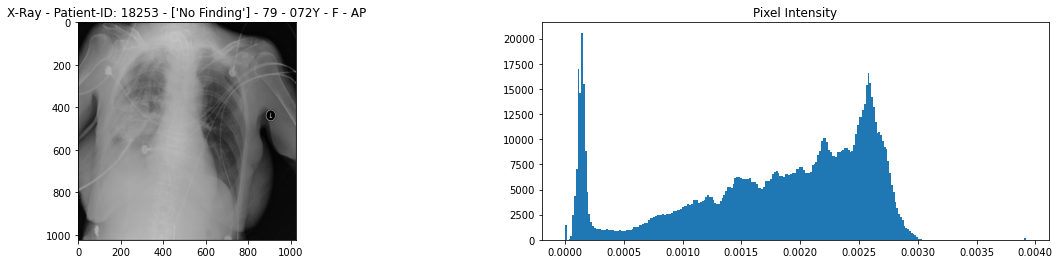

In [18]:
text= f'### Pneumonia vs No Pneumonia'
display(Markdown(text))

text= f'Images & distributions of patients with different ages and gender'
display(Markdown(text))

sample_df_tmp = sample_df[(sample_df[FINDING_LABELS_U].sum(axis=1) == sample_df['No Finding']) | \
                          (sample_df[FINDING_LABELS_U].sum(axis=1) == sample_df['Pneumonia'])]
sample_df_tmp = sample_df_tmp[sample_df_tmp['View Position'] == 'AP']
sample_df_tmp = sample_df_tmp.sort_values('Follow-up #')
sample_df_tmp['Finding Labels'] = [str(x) for x in sample_df_tmp['Finding Labels']] 
sample_df_tmp = sample_df_tmp.sample(len(sample_df_tmp))
sample_df_tmp = sample_df_tmp.drop_duplicates(subset = ['Patient Age','Patient Gender', 'Finding Labels'])
sample_df_tmp['Amount'] = sample_df_tmp.groupby(['Patient Age','Patient Gender'])['Finding Labels'].transform('size')
sample_df_tmp = sample_df_tmp[sample_df_tmp['Amount'] > 1]
sample_df_tmp = sample_df_tmp.sort_values('Patient Age')

sample_df_tmp = sample_df_tmp.sort_values(['Patient Age', 'Finding Labels', 'Patient Gender'], ascending=[True, False, True])
for _, row in sample_df_tmp.iterrows():
    plot_image_info(row, 
                    info = ['Patient ID', 'Finding Labels','Follow-up #','Patient Age','Patient Gender','View Position'],
                    img = None, 
                    norm_modus = 1)

From the above images and pixel intensities we can see that not all the images are cristal clear. But in general, healty people should have a lower pixel intensity (less brighter pixels) then non healthy people.